In [1]:
import os
import pickle
import torch
import sys

from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tabulate import tabulate


In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# fix the path
original_path = os.getcwd()
sys.path.append(os.path.join('.', '..'))
sys.path.append('/content/drive/My Drive/Deep_Learning_Project12/')
os.chdir(sys.path[-1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Data and Wrangling

In [3]:
import numpy as np
import pandas as pd

data_files = os.listdir("Files")
  
labels = pd.read_csv("Files/dermx_labels.csv")
labels["image_path"] = [os.path.join(os.getcwd(),"Files", "images", f"{x}.jpeg") for x in labels["image_id"]]
labels.drop(columns = "Unnamed: 0", inplace = True)

labels.dropna().reset_index(drop = True)
labels = pd.get_dummies(labels, columns = ["area"])
labels["open_comedo"] = (labels["open_comedo"] > 0).astype(int)

features_target = pd.read_csv("Files/diseases_characteristics.csv")
features_target.rename(columns={"Unnamed: 0":"disease"},inplace=True)

# create on_hot for diagnosis and get features
one_hot = pd.get_dummies(labels["diagnosis"])
one_hot_encoding = [list(x) for x in one_hot.values]

labels["ts"] = one_hot_encoding

# get features as multi hot
features_touse = list(labels.columns[list(range(2,9)) + [10,11,12,13]])
labels["features"] = labels.loc[:, features_touse].values.tolist()

# map feature sequences to value
features_map = {}
for idx, feat in enumerate(labels["features"].apply(tuple).unique()):
  features_map[str(feat)] = idx

labels["features_label"] = labels["features"].apply(tuple).apply(str).map(features_map)

# get domain
domain = pd.read_csv("Files/diseases_characteristics.csv")
domain.rename(columns={"Unnamed: 0":"diagnosis"},inplace=True)
domain = pd.get_dummies(domain, columns = ["area"])
same_sort = ["diagnosis"] + features_touse
domain = domain[same_sort]  # same sorting

domain_one_hot = pd.get_dummies(domain["diagnosis"])

domain_one_hot_encoding = [list(x) for x in domain_one_hot.values]
domain["ts"] = domain_one_hot_encoding
feature_cols = domain.columns[1:12]
domain["features"] = domain.loc[:,feature_cols].values.tolist()

# add domain features (domain knowledge) to dataframe
tf = []
for i, row in labels.iterrows():
  disease = row["diagnosis"]
  true_features = domain.loc[domain.diagnosis == disease].features.tolist()[0]
  tf.append(true_features)
labels["domain_features"] = tf 

domain = domain.sort_values(by="diagnosis").reset_index(drop=True)

data = labels.copy()


# Summarize k_fold



In [4]:
from HelperFunctions.project_utils import KFoldResult, plot_tracker
from sklearn.metrics import classification_report

# features
runs_labels = []
runs_features = []
runs_MTL = []

k = 5
for i in range(k):
  fname=f"K_fold/LabelsNet_FINAL_kfold_NA_{i}.json"
  run = KFoldResult(fname)
  runs_labels.append(run)

  fname=f"K_fold/Features_FINAL_kfold_NA_{i}.json"
  run = KFoldResult(fname,isMTL=False)
  runs_features.append(run)

  fname=f"K_fold/MTLNet_FINAL_kfold_NA_{i}.json"
  run = KFoldResult(fname)
  runs_MTL.append(run)
  

labels_acc = []
features_acc = []
MTL_labels_acc = []
MTL_features_acc = []
for run_l, run_f, run_MTL in zip(runs_labels, runs_features, runs_MTL):
  labels_acc.append(run_l.get_labels_accuracy())
  features_acc.append(run_f.get_features_accuracy())
  MTL_labels_acc.append(run_MTL.get_labels_accuracy())
  MTL_features_acc.append(run_MTL.get_features_accuracy())
  

In [6]:
tab_f1 = {
    "k"           :list(range(1, 5+1)) + ["Mean", "Std"],
    "FeaturesNet": [f"{v:.3f}" for v in features_acc] + [f"{np.mean(features_acc):.3f}", f"{np.std(features_acc):.3f}"],
    "MTLNet (features)"     : [f"{v:.3f}" for v in MTL_features_acc] + [f"{np.mean(MTL_features_acc):.3f}", f"{np.std(MTL_features_acc):.3f}"],
    "DiseaseNet"  : [f"{v:.3f}" for v in labels_acc] + [f"{np.mean(labels_acc):.3f}", f"{np.std(labels_acc):.3f}"],
    "MTLNet (labels)"     : [f"{v:.3f}" for v in MTL_labels_acc] + [f"{np.mean(MTL_labels_acc):.3f}", f"{np.std(MTL_labels_acc):.3f}"],
}

print(tabulate(tab_f1, headers = "keys", floatfmt=".2f"))

k       FeaturesNet    MTLNet (features)    DiseaseNet    MTLNet (labels)
----  -------------  -------------------  ------------  -----------------
1              0.75                 0.75          0.69               0.71
2              0.75                 0.82          0.81               0.74
3              0.66                 0.71          0.77               0.75
4              0.72                 0.77          0.74               0.80
5              0.72                 0.76          0.74               0.73
Mean           0.72                 0.76          0.75               0.75
Std            0.03                 0.04          0.04               0.03


# MTL Net Performance

In [7]:
metrics = {
      "Precision": [],
      "Recall": [],
      "F1 score": [],
      "Support": []
}

total_support = np.zeros(len(features_touse))
for i, run in enumerate(runs_MTL):
  pred = run.features_preds
  prob = run.features_probs
  targ = run.features_targets

  run_dict = classification_report(targ,pred, zero_division=0, target_names = features_touse, output_dict = True, digits = 2)
  run_precision = []
  run_recall = []
  run_f1 = []
  run_support = []
  tmp = []
  for key in features_touse:
    item = run_dict[key] 
    run_precision.append(item["precision"])
    run_recall.append(item["recall"])
    run_f1.append(item["f1-score"])
    run_support.append(item["support"])

    
  metrics["Precision"].append(run_precision)
  metrics["Recall"].append(run_recall)
  metrics["F1 score"].append(run_f1)
  metrics["Support"].append(run_support)
  total_support += run_support
tmp.append(metrics["Support"])
metrics["Weights"] = [support / total_support for support in metrics["Support"]]

metrics_avg = {
      "Precision": sum([p*w for p, w in zip(metrics["Precision"], metrics["Weights"])]),
      "Recall": sum([r*w for r, w in zip(metrics["Recall"], metrics["Weights"])]),
      "F1 score": sum([f*w for f, w in zip(metrics["F1 score"], metrics["Weights"])])
    }

tab = {
    "Feature":  features_touse,
    "Precision": [f"{v:.3f}" for v in metrics_avg['Precision']],
    "Recall": [f"{v:.3f}" for v in metrics_avg['Recall']],
    "F1 score": [f"{v:.3f}" for v in metrics_avg['F1 score']],
}

print(tabulate(tab, headers = "keys", floatfmt=".2f"))

Feature                    Precision    Recall    F1 score
-----------------------  -----------  --------  ----------
scale                           0.84      0.82        0.83
plaque                          0.89      0.83        0.86
pustule                         0.83      0.81        0.82
patch                           0.79      0.81        0.80
papule                          0.80      0.72        0.76
dermatoglyph_disruption         0.60      0.75        0.67
open_comedo                     0.63      0.84        0.72
area_acral_distribution         0.76      0.85        0.79
area_exposed_areas              0.67      0.50        0.57
area_extensor_sites             0.68      0.65        0.65
area_seborrheic_region          0.77      0.90        0.82


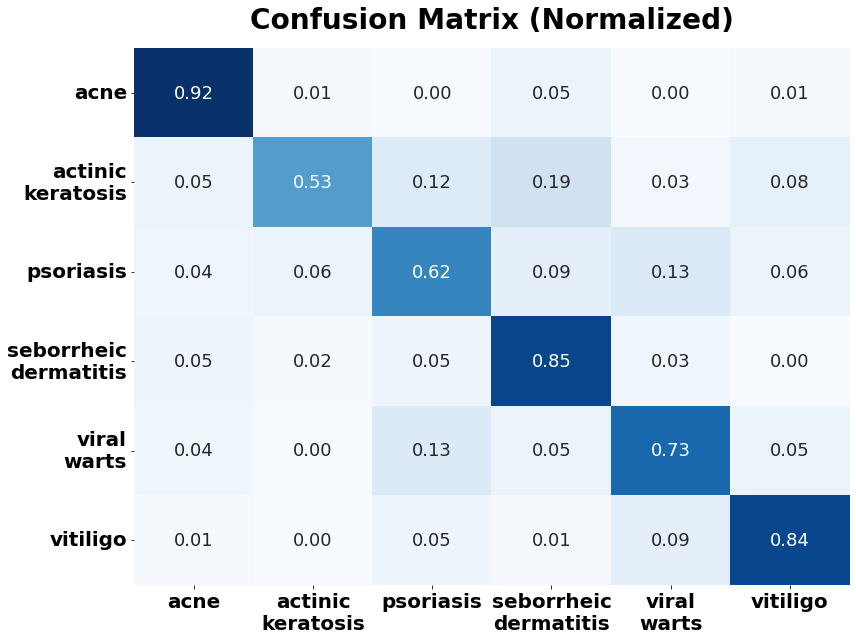

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def fix_label(label: str):
  if "area_" in label:
    label = label.replace("area_","")
  new_str = label.replace("_","\n")
  return new_str

header_size = 28
text_size = 20

def plot_conf(conf,target_labels):
  df_cm = pd.DataFrame(conf, index = [i for i in target_labels],
                              columns = [i for i in target_labels])
  plt.figure(figsize = (12,9))
  ax = sns.heatmap(df_cm, annot=True, cmap="Blues", cbar=False,
                   annot_kws={"size": 18},fmt='.2f')
  ax.set_xticklabels([fix_label(lab) for lab in target_labels], fontsize=text_size,weight="bold")
  ax.set_yticklabels([fix_label(lab) for lab in target_labels], fontsize=text_size,weight="bold", rotation = 0)
  plt.title("Confusion Matrix (Normalized)",fontsize=header_size,weight="bold",pad=20)
  
  plt.tight_layout()

  plt.show()

  

num_classes = len(np.unique(runs_MTL[0].labels_targets))
overall_conf = np.zeros(shape=(num_classes, num_classes, len(runs_MTL)))

for i, run in enumerate(runs_MTL):
  conf = confusion_matrix(run.labels_targets, run.labels_preds, normalize="true")
  overall_conf[:,:,i] = conf

plot_conf(overall_conf.mean(axis=2), sorted(data.diagnosis.unique().tolist()))

